## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [21]:
# ML imports
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torchvision import transforms

#from avalanche.training import Naive
from avalanche.models import SimpleMLP #, SimpleCNN
from avalanche.benchmarks.classic import PermutedMNIST #,PermutedOmniglot, RotatedOmniglot

from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN

In [42]:
# Config
device = utils.get_device()

model = 'mlp'
n_classes = 10
n_epochs = 3
latent_layer_number = 1

if model=='mlp':
    penultimate_layer_dim = 256
    model = SimpleMLP(input_size=784, hidden_layers=2, num_classes=n_classes, hidden_size=penultimate_layer_dim)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))])
    
elif model=='cnn':
    model = SimpleCNN(num_classes=n_classes)
    penultimate_layer_dim = 64
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose([
        #transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

perm_mnist = PermutedMNIST(n_experiences=3, train_transform=transform, eval_transform=transform)
train_stream = perm_mnist.train_stream
test_stream = perm_mnist.test_stream

# Prepare for training & testing
criterion = CrossEntropyLoss()

# Continual learning strategy
#cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device) 

cl_strategy = models.AR1(
    model=model, 
    penultimate_layer_dim=penultimate_layer_dim,
    criterion=criterion, 
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32, 
    latent_layer_num=latent_layer_number, 
    freeze_below_layer=f"lat_features.{latent_layer_number-1}", 
    device=device
    )

# train and test loop over the stream of experiences
results = []

for train_exp in train_stream:
    cl_strategy.train(train_exp)
    results.append(cl_strategy.eval(test_stream))

MobilenetV1(
  (lat_features): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
  )
  (end_features): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=256, out_features=10, bias=False)
)
-- >> Start of training phase << --
100%|██████████| 1875/1875 [00:33<00:00, 55.64it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.7257
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.4170
100%|██████████| 1875/1875 [00:24<00:00, 76.28it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6457
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8029
100%|██████████| 1875/1875 [00:24<00:00, 76.46it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4590
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8649
-- >> End of training

[{'Top1_Acc_Epoch/train_phase/train_stream/Task000': 0.86485, 'Loss_Epoch/train_phase/train_stream/Task000': 0.4589818431138992, 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000': 0.9117, 'Loss_Exp/eval_phase/test_stream/Task000/Exp000': 0.30214884734153746, 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001': 0.1277, 'Loss_Exp/eval_phase/test_stream/Task001/Exp001': 2.5533801399230955, 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002': 0.0977, 'Loss_Exp/eval_phase/test_stream/Task002/Exp002': 2.7717728122711183, 'Top1_Acc_Stream/eval_phase/test_stream/Task000': 0.9117, 'Top1_Acc_Stream/eval_phase/test_stream/Task001': 0.1277, 'Top1_Acc_Stream/eval_phase/test_stream/Task002': 0.0977, 'Loss_Stream/eval_phase/test_stream/Task000': 0.30214884734153746, 'Loss_Stream/eval_phase/test_stream/Task001': 2.5533801399230955, 'Loss_Stream/eval_phase/test_stream/Task002': 2.7717728122711183, 'Top1_Acc_Epoch/train_phase/train_stream/Task001': 0.47388617886178863, 'Loss_Epoch/train_phase/train

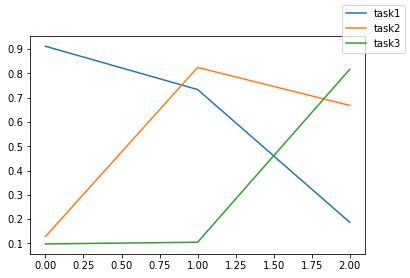

In [50]:
# JA: Next step - replace internal model.
# - model def ✅
# - frozen layer name ✅
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

results_ar1 = results
print(results_ar1)

['Top1_Acc_Epoch/train_phase/train_stream/Task000', 
 'Loss_Epoch/train_phase/train_stream/Task000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000',
 'Loss_Exp/eval_phase/test_stream/Task000/Exp000',
 'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001',
 'Loss_Exp/eval_phase/test_stream/Task001/Exp001',
 'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp002',
 'Loss_Exp/eval_phase/test_stream/Task002/Exp002',
 'Top1_Acc_Stream/eval_phase/test_stream/Task000',
 'Top1_Acc_Stream/eval_phase/test_stream/Task001',
 'Top1_Acc_Stream/eval_phase/test_stream/Task002',
 'Loss_Stream/eval_phase/test_stream/Task000',
 'Loss_Stream/eval_phase/test_stream/Task001',
 'Loss_Stream/eval_phase/test_stream/Task002',
 'Top1_Acc_Epoch/train_phase/train_stream/Task001',
 'Loss_Epoch/train_phase/train_stream/Task001',
 'Top1_Acc_Epoch/train_phase/train_stream/Task002',
 'Loss_Epoch/train_phase/train_stream/Task002']

def plotplot(results):
    results_clean = {"train":{'acc':[], 'loss':[]}, "test":{'acc':[], 'loss':[]}}
    loss_prefix = 'Loss_Stream/eval_phase/test_stream/'
    acc_prefix = 'Top1_Acc_Stream/eval_phase/test_stream/'
    
    for result in results:
        results_clean["test"]['loss'].append([
            result[f'{loss_prefix}Task000'], 
            result[f'{loss_prefix}Task001'], 
            result[f'{loss_prefix}Task002']])
        
        results_clean["test"]['acc'].append([
            result[f'{acc_prefix}Task000'], 
            result[f'{acc_prefix}Task001'], 
            result[f'{acc_prefix}Task002']])
        
       # results_clean["train"]['loss'].append([
       #     result['Loss_Epoch/train_phase/train_stream/Task000'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task001'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task002']])
    
    return results_clean
        
results_ar1_clean = plotplot(results)
results_ar1_clean

fig, axes = plt.subplots(1,1)

axes.plot(results_ar1_clean["test"]['acc'], label=['task1','task2','task3'])
fig.legend()


In [51]:
results_ar1_clean["test"]['acc']

[[0.9117, 0.1277, 0.0977], [0.7334, 0.8244, 0.1046], [0.1867, 0.6679, 0.8168]]